In [1]:
library(tidyr)
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
similarity <- read.csv('../../interneuron-reward-data/processed/mean_fluo_df.csv')

# Convert numeric cell_id to factor
similarity[, 'day'] <- as.factor(similarity[, 'day'])
similarity[, 'cell_id'] <- as.factor(similarity[, 'cell_id'])

# Display first few rows
head(similarity)

day,cell_type,cell_id,mouse_id,tone,tone.shuf,tone...delay,tone...delay.shuf,reward,reward.shuf
1,vip,3121,CL136,-0.04264971,0.3060694,-0.08960109,0.017134295,-0.11040496,-0.06937511
7,vip,3121,CL136,-0.20564170,0.3613687,-0.02291315,-0.294750321,-0.32023506,-0.34300373
1,vip,3122,CL136,0.11017130,0.1176927,0.04822452,0.028460844,-0.31156678,-0.03187037
7,vip,3122,CL136,-0.24034267,0.2850437,-0.42962872,-0.005981111,-0.05429231,-0.41547053
1,vip,3123,CL136,-0.06273525,-0.1307697,-0.04521951,-0.055852600,-0.02233526,-0.01066198
7,vip,3123,CL136,-0.06965835,0.2427358,-0.04938029,-0.036955755,-0.04319692,-0.05839529


In [3]:
similarity %>% gather("trial_component", 'tuning', 'tone...delay', 'reward') %>% 
subset(select=c('day', 'cell_type', 'cell_id', 'mouse_id', 'trial_component', 'tuning')) %>% 
head

day,cell_type,cell_id,mouse_id,trial_component,tuning
1,vip,3121,CL136,tone...delay,-0.08960109
7,vip,3121,CL136,tone...delay,-0.02291315
1,vip,3122,CL136,tone...delay,0.04822452
7,vip,3122,CL136,tone...delay,-0.42962872
1,vip,3123,CL136,tone...delay,-0.04521951
7,vip,3123,CL136,tone...delay,-0.04938029


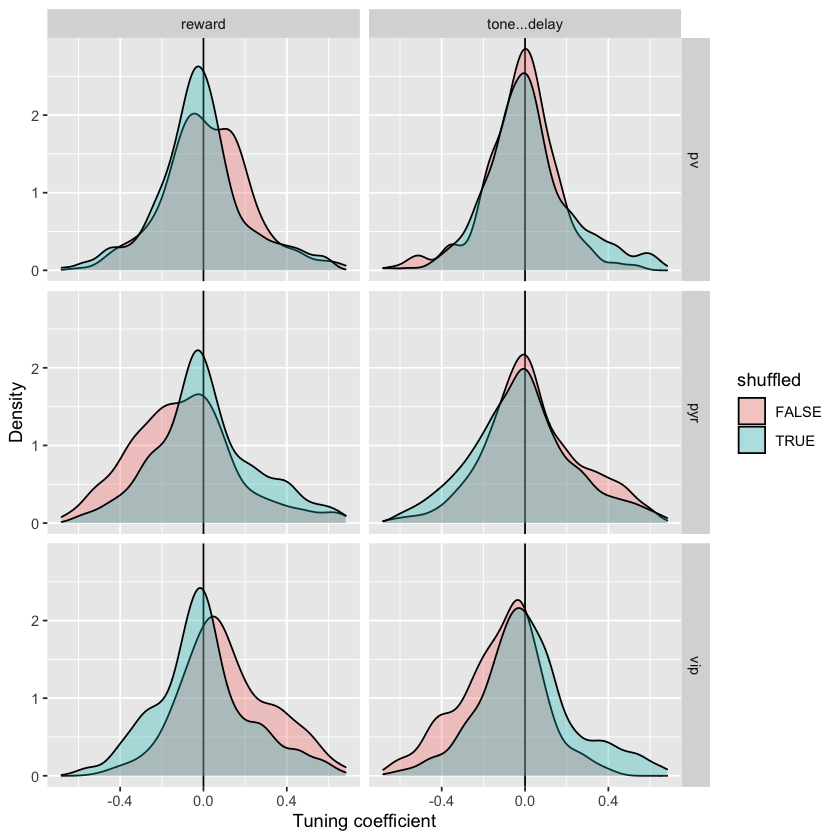

In [5]:
similarity_long <- similarity %>% gather("trial_component", 'tuning', 'tone...delay', 'reward')
similarity_long['shuffled'] <- FALSE
similarity_long <- subset(
    similarity_long, select=c('day', 'cell_type', 'cell_id', 'mouse_id', 'trial_component', 'tuning', 'shuffled'))

shuf <- similarity %>% gather("trial_component", 'tuning', 'tone...delay.shuf', 'reward.shuf')
shuf['shuffled'] <- TRUE
shuf['trial_component'] <- apply(shuf['trial_component'], 1, function(x) sub('.shuf$', '', x))
shuf <- subset(
    shuf, select=c('day', 'cell_type', 'cell_id', 'mouse_id', 'trial_component', 'tuning', 'shuffled'))
similarity_long <- rbind(similarity_long, shuf)

per_mouse_similarity <- (
    ggplot(
        similarity_long[similarity_long$day == 7, ], 
        aes(x=tuning, fill=shuffled)
    )
    + facet_grid(rows=vars(cell_type), cols=vars(trial_component))
    + geom_vline(xintercept=0)
    + geom_density(alpha=0.3)
    + labs(y='Density', x='Tuning coefficient')
)

ggsave(file='../img/graphics/per_mouse_similarity.svg', plot=per_mouse_similarity, width=6, height=6)

per_mouse_similarity

In [7]:
difference_dfs <- list()

for (response_variable in c('reward', 'tone...delay', 'reward.shuf', 'tone...delay.shuf')) {
    difference <- (
        similarity[, c('day', 'cell_id', 'cell_type', 'mouse_id', response_variable)] 
        %>% spread(day, response_variable)
    )
    difference[, 'tuning_change'] <- difference[,"7"] - difference[,"1"]
    difference <- difference[, !(colnames(difference) %in% c("1", "7"))]
    
    difference_dfs[[response_variable]] <- difference
}

In [8]:
difference_dfs[['reward']][, 'trial_component'] <- 'Reward tuning'
difference_dfs[['reward']][, 'shuffled'] <- FALSE
difference_dfs[['reward.shuf']][, 'trial_component'] <- 'Reward tuning'
difference_dfs[['reward.shuf']][, 'shuffled'] <- TRUE
difference_dfs[['tone...delay']][, 'trial_component'] <- 'Tone tuning'
difference_dfs[['tone...delay']][, 'shuffled'] <- FALSE
difference_dfs[['tone...delay.shuf']][, 'trial_component'] <- 'Tone tuning'
difference_dfs[['tone...delay.shuf']][, 'shuffled'] <- TRUE


difference <- rbind(
    difference_dfs[['reward']], 
    difference_dfs[['tone...delay']],
    difference_dfs[['reward.shuf']],
    difference_dfs[['tone...delay.shuf']]
)
head(difference)

cell_id,cell_type,mouse_id,tuning_change,trial_component,shuffled
1,pyr,CL174,-0.1041927,Reward tuning,FALSE
2,pyr,CL174,0.1412351,Reward tuning,FALSE
3,pyr,CL174,-0.5789253,Reward tuning,FALSE
4,pyr,CL174,-0.1445291,Reward tuning,FALSE
5,pyr,CL174,0.5753425,Reward tuning,FALSE
6,pyr,CL174,0.5649983,Reward tuning,FALSE


In [9]:
summary(difference)

    cell_id     cell_type     mouse_id    tuning_change      
 1      :   4   pv :1248   CL176  :1196   Min.   :-1.247365  
 2      :   4   pyr:4828   CL182  :1020   1st Qu.:-0.209743  
 3      :   4   vip:1628   CL174  : 844   Median :-0.003987  
 4      :   4              CL184  : 744   Mean   :-0.008967  
 5      :   4              CL181  : 732   3rd Qu.: 0.190153  
 6      :   4              CL136  : 480   Max.   : 1.208069  
 (Other):7680              (Other):2688   NA's   :4          
 trial_component     shuffled      
 Length:7704        Mode :logical  
 Class :character   FALSE:3852     
 Mode  :character   TRUE :3852     
                                   
                                   
                                   
                                   

Warning message:
“Removed 4 rows containing non-finite values (stat_density).”Warning message:
“Removed 4 rows containing non-finite values (stat_density).”

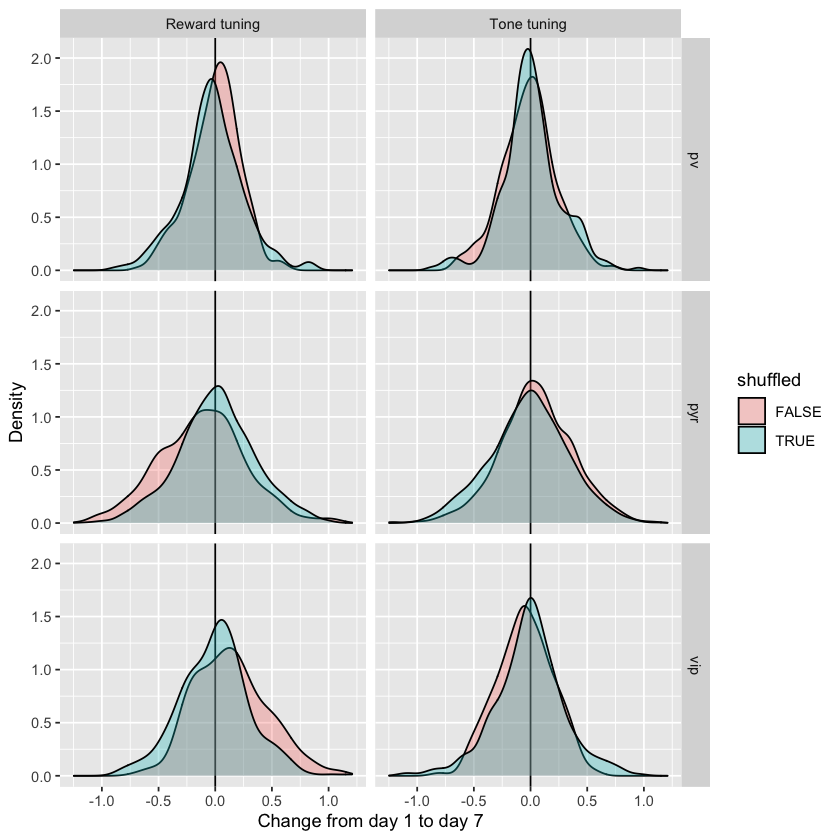

In [10]:
per_mouse_similarity_change <- (
    ggplot(difference, aes(x=tuning_change, fill=shuffled))
    + facet_grid(rows=vars(cell_type), cols=vars(trial_component))
    + geom_vline(xintercept=0)
    + geom_density(alpha=0.3)
    + labs(y='Density', x='Change from day 1 to day 7')
)

ggsave(file='../img/graphics/per_mouse_similarity_change.svg', plot=per_mouse_similarity_change, width=6, height=6)

per_mouse_similarity_change

# Out of date past here as of Jan 19, 2021

In [7]:
difference_stats <- list()
num_mice <- length(unique(difference[, 'mouse_id']))

for (trial_component in unique(difference[, 'trial_component'])) {
    # Allocate data frame for storing p-values
    difference_stats[[trial_component]] <- data.frame(
        mouse_id=unique(difference[, 'mouse_id']), 
        cell_type=factor(character(num_mice), levels=levels(difference[, 'cell_type'])), 
        greater_p_value=numeric(num_mice),
        less_p_value=numeric(num_mice)
    )

    for (mouse_id in unique(difference[, 'mouse_id'])) {
        # Compute masks for selecting data
        this_row_mask <- (difference_stats[[trial_component]][, 'mouse_id'] == mouse_id)
        diff_row_mask <- (
            (difference[, 'mouse_id'] == mouse_id) 
            & (difference[, 'trial_component'] == trial_component)
        )
        
        # Store cell type
        difference_stats[[trial_component]][this_row_mask, 'cell_type'] <- difference[
            diff_row_mask, 'cell_type'
        ][1]
        
        # Compute p-values for positive or negative tuning change
        difference_stats[[trial_component]][this_row_mask, 'greater_p_value'] <- wilcox.test(
            difference[diff_row_mask, 'tuning_change'], 
            alternative='greater'
        )$p.value
        difference_stats[[trial_component]][this_row_mask, 'less_p_value'] <- wilcox.test(
            difference[diff_row_mask, 'tuning_change'], 
            alternative='less'
        )$p.value
    }
    
    difference_stats[[trial_component]][, 'trial_component'] <- trial_component
}

difference_stats <- rbind(difference_stats[['Reward tuning']], difference_stats[['Tone tuning']])

In [8]:
difference_stats[, 'greater_significance'] <- difference_stats[, 'greater_p_value'] < 0.05
difference_stats[, 'less_significance'] <- difference_stats[, 'less_p_value'] < 0.05

any(difference_stats[, 'greater_significance'] & difference_stats[, 'less_significance'])

[1] FALSE

If the above outputs `FALSE`, there are no mice that exhibit *both* a significant increase and decrease in tuning. This is a sanity check and `FALSE` is the expected result.

In [9]:
signif_counts <- merge(
    merge(
        aggregate(
            rep(1, nrow(difference_stats)), 
            by=list(difference_stats$cell_type, difference_stats$trial_component), 
            FUN=sum
        ) %>% rename(num_mice=x, cell_type=Group.1, trial_component=Group.2),
        aggregate(
            difference_stats$greater_significance, 
            by=list(difference_stats$cell_type, difference_stats$trial_component), 
            FUN=sum
        ) %>% rename(num_greater_signif=x, cell_type=Group.1, trial_component=Group.2)
    ),
    aggregate(
        difference_stats$less_significance, 
        by=list(difference_stats$cell_type, difference_stats$trial_component), 
        FUN=sum
    ) %>% rename(num_less_signif=x, cell_type=Group.1, trial_component=Group.2)
)

signif_counts

cell_type,trial_component,num_mice,num_greater_signif,num_less_signif
pv,Reward tuning,6,3,3
pv,Tone tuning,6,1,3
pyr,Reward tuning,6,1,4
pyr,Tone tuning,6,3,1
vip,Reward tuning,4,3,1
vip,Tone tuning,4,1,3


In [10]:
omnibus_test <- function(num_significant_p_values, num_tests, alpha_level) {
    if (num_significant_p_values == 0) {
        return(1.0)
    } else {
        return(
            pbinom(num_significant_p_values - 1, num_tests, alpha_level, lower.tail=FALSE)
        )
    }
}

In [11]:
signif_counts[, 'greater_signif_p'] <- apply(
    signif_counts, 1, 
    function(row) omnibus_test(as.numeric(row['num_greater_signif']), as.numeric(row['num_mice']), 0.05)
)
signif_counts[, 'greater_signif_flag_bonferroni'] <- signif_counts[, 'greater_signif_p'] < (0.05 / 12)

signif_counts[, 'less_signif_p'] <- apply(
    signif_counts, 1, 
    function(row) omnibus_test(as.numeric(row['num_less_signif']), as.numeric(row['num_mice']), 0.05)
)
signif_counts[, 'less_signif_flag_bonferroni'] <- signif_counts[, 'less_signif_p'] < (0.05 / 12)

signif_counts

cell_type,trial_component,num_mice,num_greater_signif,num_less_signif,greater_signif_p,greater_signif_flag_bonferroni,less_signif_p,less_signif_flag_bonferroni
pv,Reward tuning,6,3,3,0.002229844,TRUE,2.229844e-03,TRUE
pv,Tone tuning,6,1,3,0.264908109,FALSE,2.229844e-03,TRUE
pyr,Reward tuning,6,1,4,0.264908109,FALSE,8.640625e-05,TRUE
pyr,Tone tuning,6,3,1,0.002229844,TRUE,2.649081e-01,FALSE
vip,Reward tuning,4,3,1,0.000481250,TRUE,1.854938e-01,FALSE
vip,Tone tuning,4,1,3,0.185493750,FALSE,4.812500e-04,TRUE


After Bonferroni correction for 12 comparisons, we find the following:
- PV 
    - become activated or inhibited by reward, depending on the mouse
    - become inhibited by tone in at least some mice
- PYR
    - become inhibited by reward in at least some mice
    - become activated by tone in at least some mice
- VIP
    - become activated by reward in at least some mice
    - become inhibited by tone in at least some mice

In [12]:
median_differences <- aggregate(
    difference$tuning_change, 
    by=list(difference$cell_type, difference$mouse_id, difference$trial_component),
    FUN=function(x) median(x, na.rm=TRUE)
) %>% rename(cell_type=Group.1, mouse_id=Group.2, trial_component=Group.3, tuning_change=x)

aggregate(
    median_differences$tuning_change,
    by=list(median_differences$cell_type, median_differences$trial_component),
    FUN=function(x) wilcox.test(x, alternative='two.sided')$p.value
)

Group.1,Group.2,x
pv,Reward tuning,0.84375
pyr,Reward tuning,0.15625
vip,Reward tuning,0.37500
pv,Tone tuning,0.56250
pyr,Tone tuning,0.43750
vip,Tone tuning,0.37500


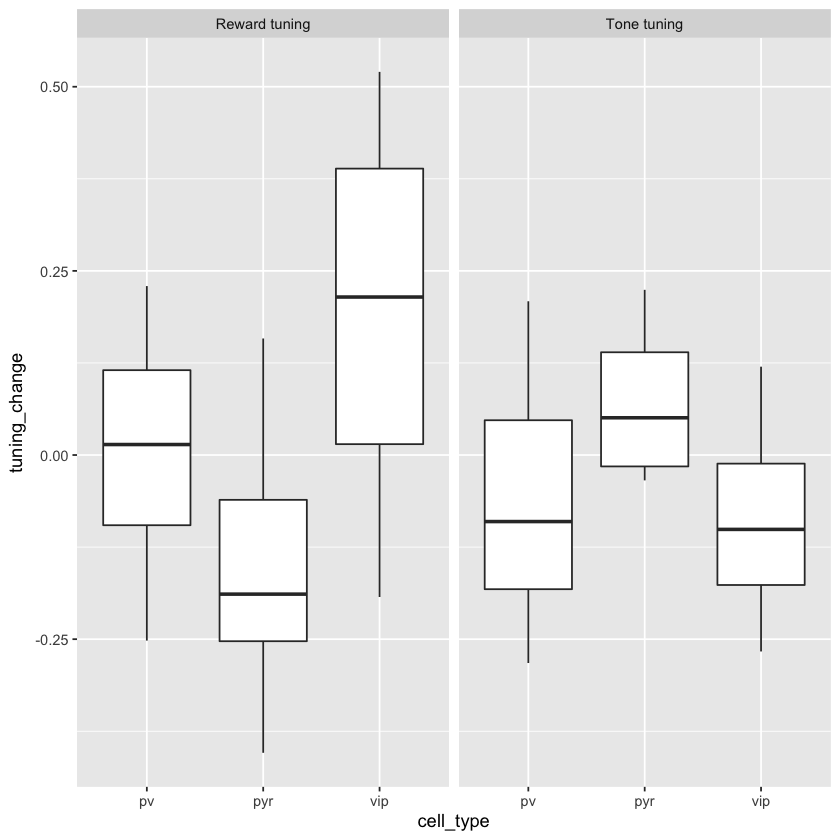

In [13]:
ggplot(median_differences, aes(x=cell_type, y=tuning_change)) +
    facet_grid(cols=vars(trial_component)) +
    geom_boxplot()